In [2]:
import os
import time
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

Configs

In [3]:
DATASETS = ['dataset1', 'dataset2']
FEATURES_DIR = 'extracted_features'
MODELS_DIR = 'models'
RESULTS_DIR = 'results'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

Helper Methods

In [4]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name, dataset_name, results_dir):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Dataset: {dataset_name}\nModel: {model_name} - Confusion Matrix')
    plt.tight_layout()
    output_path = os.path.join(results_dir, f"{dataset_name}_{model_name}_best_confusion_matrix.png")
    plt.savefig(output_path)
    plt.show()

Define hyperparameter search values and pipelines for each model (SVM, GradientBoosting, MLP)

In [5]:
model_params = {
    'SVM': {'classifier__C': [1, 10], 'classifier__gamma': ['scale', 0.001]},
    'GradientBoosting': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1]},
    'MLP': {'classifier__hidden_layer_sizes': [(50,), (100,)], 'classifier__alpha': [0.0001, 0.001]}
}

pipelines = {
    'SVM': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('classifier', SVC(probability=True, random_state=42))]),
    'GradientBoosting': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('classifier', GradientBoostingClassifier(random_state=42))])
}

all_feature_sets = [f for f in os.listdir(FEATURES_DIR) if f.endswith('.npz')]
print(all_feature_sets)

['dataset1_hog16x16_lbp12p1r.npz', 'dataset1_hog16x16_lbp12p2r.npz', 'dataset1_hog16x16_lbp8p1r.npz', 'dataset1_hog16x16_lbp8p2r.npz', 'dataset1_hog8x8_lbp12p1r.npz', 'dataset1_hog8x8_lbp12p2r.npz', 'dataset1_hog8x8_lbp8p1r.npz', 'dataset1_hog8x8_lbp8p2r.npz', 'dataset2_hog16x16_lbp12p1r.npz', 'dataset2_hog16x16_lbp12p2r.npz', 'dataset2_hog16x16_lbp8p1r.npz', 'dataset2_hog16x16_lbp8p2r.npz', 'dataset2_hog8x8_lbp12p1r.npz', 'dataset2_hog8x8_lbp12p2r.npz', 'dataset2_hog8x8_lbp8p1r.npz', 'dataset2_hog8x8_lbp8p2r.npz']


Main loop for the 2 datasets

In [6]:
def train_model(pipelines, feature_sets):
    for dataset_name in DATASETS:
        print(f'dataset: {dataset_name}\n')
        print('#' * 80)

        results_for_dataset = {}
        dataset_feature_sets = [f for f in feature_sets if f.startswith(dataset_name)]

        # try models for each dataset

        for model_name, pipeline in pipelines.items():
            print(f'searching best feature set for {model_name}\n')
            print("-"*80)
            start_time = time.time()

            curr_model_best_score = 0
            curr_model_best_config = {}
            param_grid = model_params[model_name]

            for feature_file in dataset_feature_sets:
                feature_set_name = os.path.splitext(feature_file)[0]
                print(f'\n--- trying: {feature_set_name} ---')
                
                filepath = os.path.join(FEATURES_DIR, feature_file)
                with np.load(filepath, allow_pickle=True) as data:
                    X, y, class_map = data['features'], data['labels'], data['class_map'].item()
                
                class_names = list(class_map.keys())
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
                
                grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=2, verbose=2)
                grid_search.fit(X_train, y_train)
                
                accuracy = grid_search.score(X_test, y_test)
                print(f'accuracy for {model_name} with {feature_set_name}: {accuracy:.4f}')

                if accuracy > curr_model_best_score:
                    curr_model_best_score = accuracy
                    curr_model_best_config = {
                        'model_name': model_name, 'feature_set': feature_set_name,
                        'pipeline': grid_search.best_estimator_, 'best_params': grid_search.best_params_,
                        'X_test': X_test, 'y_test': y_test, 'class_names': class_names
                    }
            
            # save best result after trying all feature set combinations

            if curr_model_best_config:
                results_for_dataset[model_name] = curr_model_best_config
                best_to_save = curr_model_best_config['pipeline']
                best_model_path = os.path.join(MODELS_DIR, f'{dataset_name}_{model_name}_best_model.pkl')
                joblib.dump(best_to_save, best_model_path)
                print(f"saved best {model_name} model to {best_model_path}")
            print(f'\nfinished tuning for {model_name} in {(time.time() - start_time) / 60:.2f} minutes')
                
        
        # save and print summary report for the dataset

        print('\n' + '-' * 80)
        print(f'REPORT: {dataset_name.upper()}\n')
        print('-' * 80)

        summary_data = []

        for model_name, best_config in results_for_dataset.items():
            print(f'\n--- best performance for {model_name}  ---')
            
            best_pipeline = best_config['pipeline']
            y_pred = best_pipeline.predict(best_config['X_test'])
            report_dict = classification_report(best_config['y_test'], y_pred, target_names=best_config['class_names'], output_dict=True)
            
            print(f"\nbest feature set: {best_config['feature_set']}")
            print(f"\nbest hyperparameters: {best_config['best_params']}")
            print('\nclassification report:\n')
            print(classification_report(best_config['y_test'], y_pred, target_names=best_config['class_names']))
            
            plot_confusion_matrix(y_true=best_config['y_test'], y_pred=y_pred, class_names=best_config['class_names'], model_name=model_name, dataset_name=dataset_name, results_dir=RESULTS_DIR)
            
            summary_data.append({
                'Model': model_name, 'Best Feature Set': best_config['feature_set'], 'Best Params': str(best_config['best_params']),
                'Accuracy': report_dict['accuracy'], 'F1-Score (Macro)': report_dict['macro avg']['f1-score'],
                'Precision (Macro)': report_dict['macro avg']['precision'], 'Recall (Macro)': report_dict['macro avg']['recall'],
            })

        if summary_data:
            print('\n' + '-' * 80)
            print(f"COMPARISON TABLE FOR {dataset_name.upper()}")
            print('-' * 80)
            df_final_summary = pd.DataFrame(summary_data).sort_values(by="Accuracy", ascending=False).set_index('Model')
            print(df_final_summary.to_string())

    print('\n\n' + '#' * 80)
    print("DONE")
    print('\n' + '#' * 80)

In [ ]:
train_model(pipelines=pipelines, feature_sets=all_feature_sets)



dataset: dataset1

################################################################################
searching best feature set for SVM

--------------------------------------------------------------------------------

--- trying: dataset1_hog16x16_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp12p1r: 0.6424

--- trying: dataset1_hog16x16_lbp12p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp12p2r: 0.6519

--- trying: dataset1_hog16x16_lbp8p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp8p1r: 0.6475

--- trying: dataset1_hog16x16_lbp8p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp8p2r: 0.6424

--- trying: dataset1_hog8x8_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog8x8_lbp

Gradient Boosting training does not work for some reason, as seen above (it had been running for hours). Let's try getting a result from MLP

In [17]:
pipelines = {
    'MLP': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('classifier', MLPClassifier(max_iter=500, early_stopping=True, random_state=42))])
}

dataset: dataset1

################################################################################
searching best feature set for MLP

--------------------------------------------------------------------------------

--- trying: dataset1_hog16x16_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for MLP with dataset1_hog16x16_lbp12p1r: 0.6016

--- trying: dataset1_hog16x16_lbp12p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for MLP with dataset1_hog16x16_lbp12p2r: 0.6045

--- trying: dataset1_hog16x16_lbp8p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for MLP with dataset1_hog16x16_lbp8p1r: 0.5892

--- trying: dataset1_hog16x16_lbp8p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for MLP with dataset1_hog16x16_lbp8p2r: 0.5659

--- trying: dataset1_hog8x8_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for MLP with dataset1_hog8x8_lbp

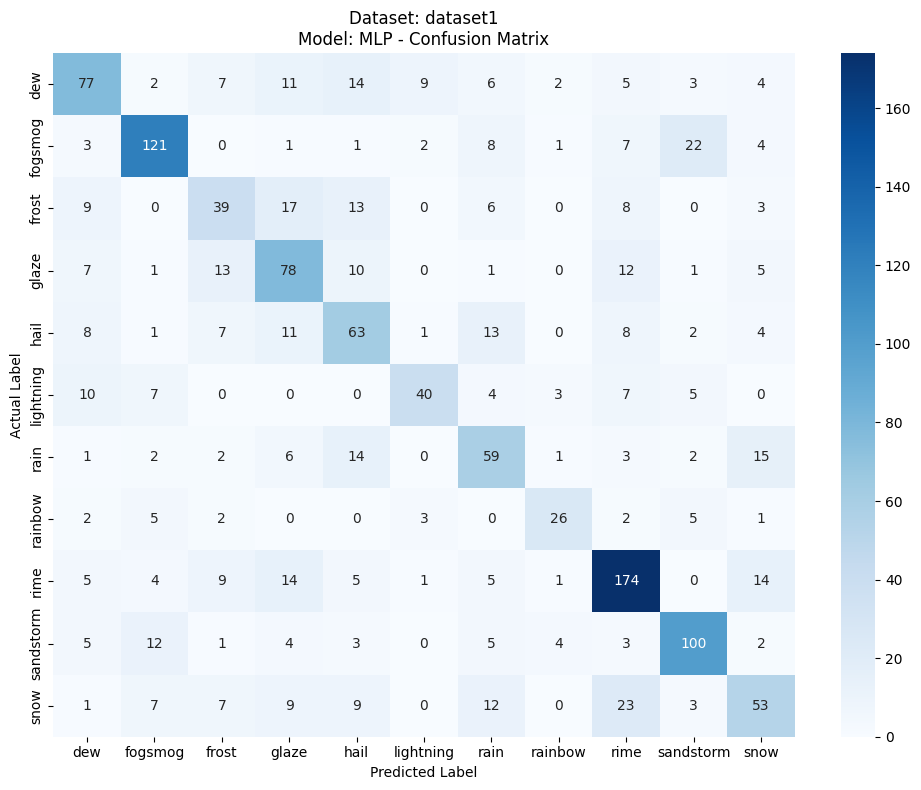


--------------------------------------------------------------------------------
COMPARISON TABLE FOR DATASET1
--------------------------------------------------------------------------------
                 Best Feature Set                                                              Best Params  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
Model                                                                                                                                                                    
MLP    dataset1_hog16x16_lbp12p2r  {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,)}  0.604516          0.585296           0.598129        0.578713

comparison table saved to results/dataset1_final_model_comparison_summary.csv 
dataset: dataset2

################################################################################
searching best feature set for MLP

--------------------------------------------------------------------------------


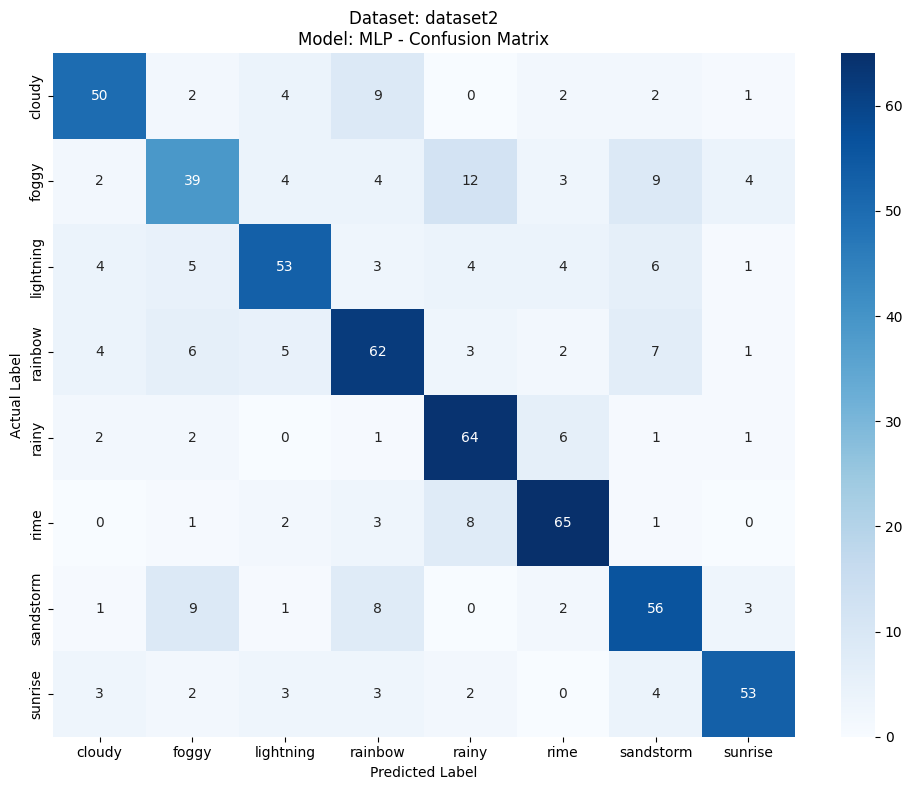


--------------------------------------------------------------------------------
COMPARISON TABLE FOR DATASET2
--------------------------------------------------------------------------------
                 Best Feature Set                                                              Best Params  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
Model                                                                                                                                                                    
MLP    dataset2_hog16x16_lbp12p2r  {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,)}  0.708333          0.708385           0.711566        0.709122

comparison table saved to results/dataset2_final_model_comparison_summary.csv 


################################################################################
DONE


################################################################################


In [9]:
train_model(pipelines=pipelines, feature_sets=all_feature_sets)

Reevaluate for SVM since it was interrupted before:

In [18]:
pipelines = {
    'SVM': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('classifier', SVC(probability=True, random_state=42))])
}

dataset: dataset1

################################################################################
searching best feature set for SVM

--------------------------------------------------------------------------------

--- trying: dataset1_hog16x16_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp12p1r: 0.6424

--- trying: dataset1_hog16x16_lbp12p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp12p2r: 0.6519

--- trying: dataset1_hog16x16_lbp8p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp8p1r: 0.6475

--- trying: dataset1_hog16x16_lbp8p2r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog16x16_lbp8p2r: 0.6424

--- trying: dataset1_hog8x8_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset1_hog8x8_lbp

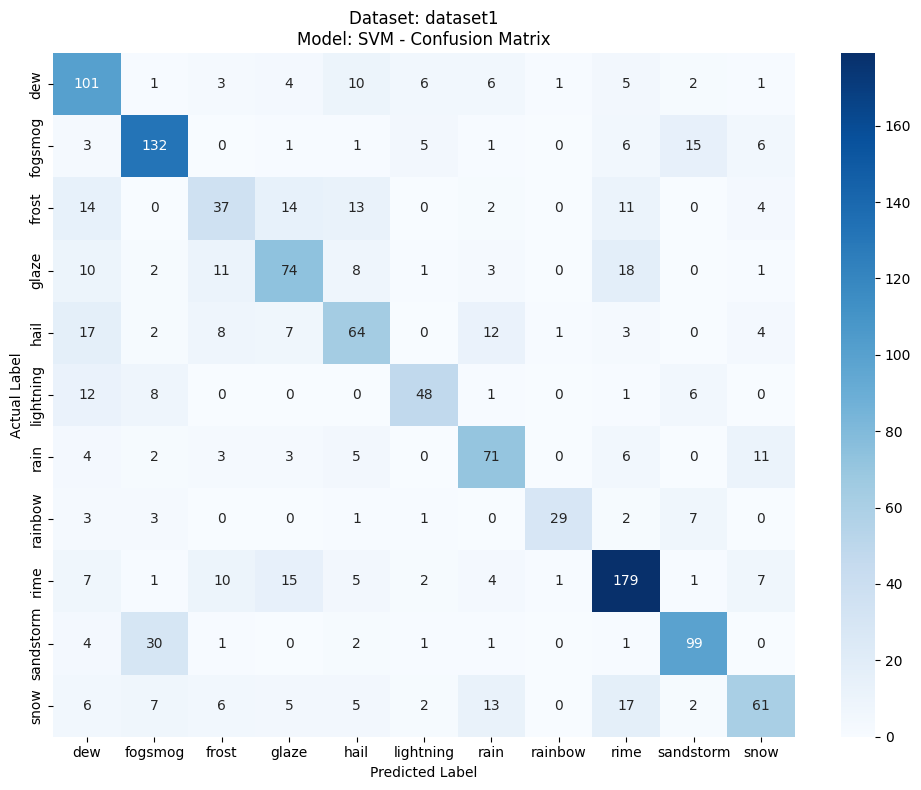


--------------------------------------------------------------------------------
COMPARISON TABLE FOR DATASET1
--------------------------------------------------------------------------------
                 Best Feature Set                                          Best Params  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
Model                                                                                                                                                
SVM    dataset1_hog16x16_lbp12p2r  {'classifier__C': 10, 'classifier__gamma': 'scale'}  0.651857            0.6394           0.659894        0.629254
dataset: dataset2

################################################################################
searching best feature set for SVM

--------------------------------------------------------------------------------

--- trying: dataset2_hog16x16_lbp12p1r ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
accuracy for SVM with dataset2_hog16

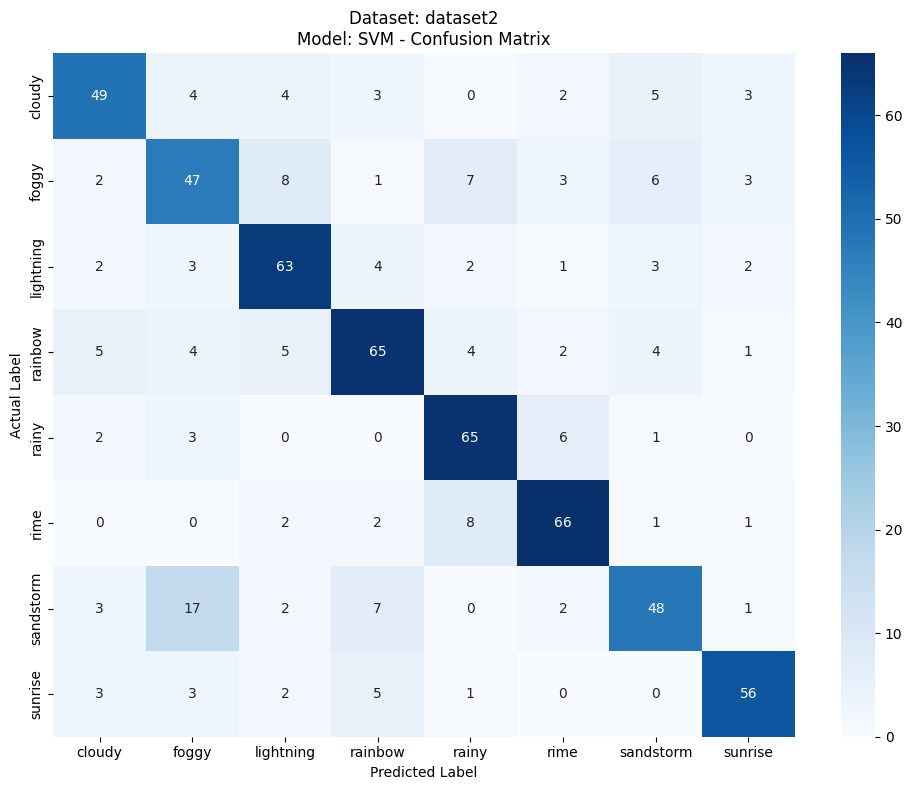


--------------------------------------------------------------------------------
COMPARISON TABLE FOR DATASET2
--------------------------------------------------------------------------------
                 Best Feature Set                                          Best Params  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
Model                                                                                                                                                
SVM    dataset2_hog16x16_lbp12p2r  {'classifier__C': 10, 'classifier__gamma': 'scale'}  0.735577          0.735336           0.737008        0.736158


################################################################################
DONE

################################################################################


In [19]:
train_model(pipelines=pipelines, feature_sets=all_feature_sets)

Let's try LightGBM instead of GradientBoosting for better speed:

In [7]:
from lightgbm import LGBMClassifier

In [8]:
model_params = {
    'LGBM': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.1, 0.05], 'classifier__num_leaves': [20, 31]}
}

pipelines = {
    'LGBM': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('classifier', LGBMClassifier(random_state=42))])
}

In [9]:
train_model(pipelines=pipelines, feature_sets=all_feature_sets)

dataset: dataset1

################################################################################
searching best feature set for LGBM

--------------------------------------------------------------------------------

--- trying: dataset1_hog16x16_lbp12p1r ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119850
[LightGBM] [Info] Number of data points in the train set: 5489, number of used features: 470
[LightGBM] [Info] Start training from score -2.286142
[LightGBM] [Info] Start training from score -2.086939
[LightGBM] [Info] Start training from score -2.670330
[LightGBM] [Info] Start training from score -2.374132
[LightGBM] [Info] Start training from score -2.451406
[LightGBM] [Info] Start training from score -2.903391
[LightGBM] [Info] Start training from score -2.567869
[LightGBM

c:\Users\Melih\Desktop\betul proje\weather-image-classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


accuracy for LGBM with dataset1_hog16x16_lbp12p1r: 0.5834

--- trying: dataset1_hog16x16_lbp12p2r ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119595
[LightGBM] [Info] Number of data points in the train set: 5489, number of used features: 469
[LightGBM] [Info] Start training from score -2.286142
[LightGBM] [Info] Start training from score -2.086939
[LightGBM] [Info] Start training from score -2.670330
[LightGBM] [Info] Start training from score -2.374132
[LightGBM] [Info] Start training from score -2.451406
[LightGBM] [Info] Start training from score -2.903391
[LightGBM] [Info] Start training from score -2.567869
[LightGBM] [Info] Start training from score -3.384755
[LightGBM] [Info] Start training from score -1.777470
[LightGBM] [Info] Start training from score -2.295143
[LightG

c:\Users\Melih\Desktop\betul proje\weather-image-classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


accuracy for LGBM with dataset1_hog16x16_lbp12p2r: 0.5863

--- trying: dataset1_hog16x16_lbp8p1r ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119595
[LightGBM] [Info] Number of data points in the train set: 5489, number of used features: 469
[LightGBM] [Info] Start training from score -2.286142
[LightGBM] [Info] Start training from score -2.086939
[LightGBM] [Info] Start training from score -2.670330
[LightGBM] [Info] Start training from score -2.374132
[LightGBM] [Info] Start training from score -2.451406
[LightGBM] [Info] Start training from score -2.903391
[LightGBM] [Info] Start training from score -2.567869
[LightGBM] [Info] Start training from score -3.384755
[LightGBM] [Info] Start training from score -1.777470
[LightGBM] [Info] Start training from score -2.295143
[LightGB

c:\Users\Melih\Desktop\betul proje\weather-image-classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


accuracy for LGBM with dataset1_hog16x16_lbp8p1r: 0.5841

--- trying: dataset1_hog16x16_lbp8p2r ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119595
[LightGBM] [Info] Number of data points in the train set: 5489, number of used features: 469
[LightGBM] [Info] Start training from score -2.286142
[LightGBM] [Info] Start training from score -2.086939
[LightGBM] [Info] Start training from score -2.670330
[LightGBM] [Info] Start training from score -2.374132
[LightGBM] [Info] Start training from score -2.451406
[LightGBM] [Info] Start training from score -2.903391
[LightGBM] [Info] Start training from score -2.567869
[LightGBM] [Info] Start training from score -3.384755
[LightGBM] [Info] Start training from score -1.777470
[LightGBM] [Info] Start training from score -2.295143
[LightGBM

c:\Users\Melih\Desktop\betul proje\weather-image-classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


accuracy for LGBM with dataset1_hog16x16_lbp8p2r: 0.5834

--- trying: dataset1_hog8x8_lbp12p1r ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
